<a href="https://colab.research.google.com/github/yiruchen4/Chen2025/blob/main/Code/ChenFigureS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pingouin > /dev/null 2>&1
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pingouin as pg
import warnings
from scipy.stats import ttest_rel

warnings.filterwarnings("ignore")

# For plotting stars above barplot
def plot_sig_line(ax, x1, x2, y, p_val):
    if p_val < 0.0001:
        stars = '****'
    elif p_val < 0.001:
        stars = '***'
    elif p_val < 0.01:
        stars = '**'
    elif p_val < 0.05:
        stars = '*'
    else:
        return
    ax.plot([x1, x2], [y, y], lw=1.2, c='grey')
    ax.text((x1 + x2) / 2, y, stars, ha='center', va='bottom', fontsize=13, fontweight='bold')


Repeated Measures ANOVA (Pingouin):
   Source            SS  DF           MS         F     p-unc       ng2  \
0   mode   7331.856659   2  3665.928329  5.225637  0.016238  0.167048   
1  Error  12627.496453  18   701.527581       NaN       NaN       NaN   

        eps  
0  0.858254  
1       NaN  

Post Hoc Paired t-tests (Holm-corrected):
         A           B         T     p-unc    p-corr     cohen
0   Empty      Social  1.267967  0.236628  0.236628  0.434681
1   Empty  Extinction  3.097565  0.012773  0.038318  0.975108
2  Social  Extinction  2.273827  0.049055  0.098110  0.676601


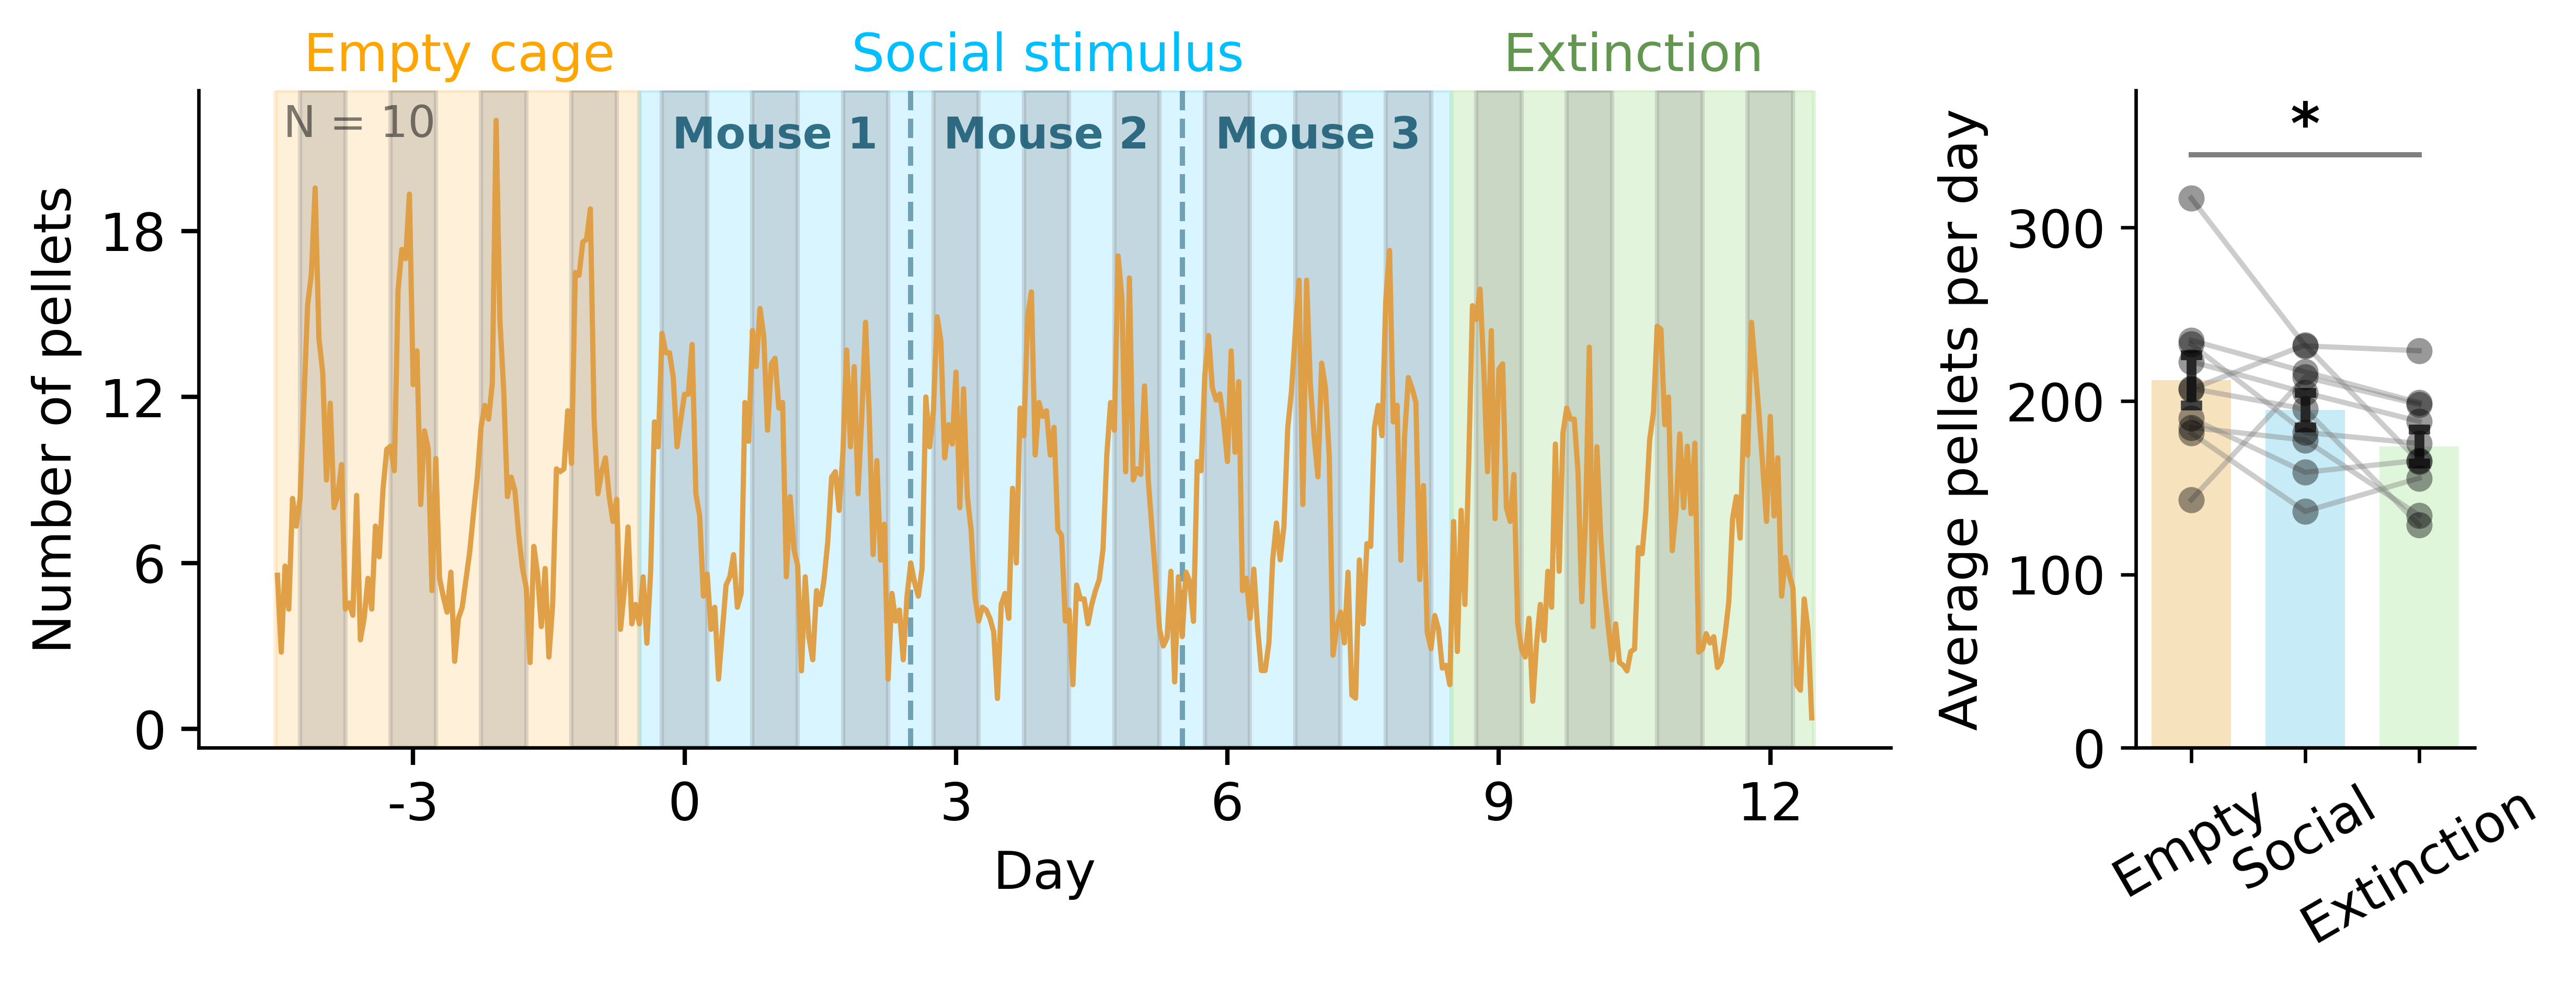

In [2]:
poke_counts = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/data_FigureS2.csv")

# === PLOTTING ===
fig = plt.figure(figsize=(8.33, 3.25), dpi=600)
gs = fig.add_gridspec(1, 2, width_ratios=[3, 0.6])

# === LEFT PLOT: Timecourse ===
ax1 = fig.add_subplot(gs[0, 0])

# Background spans
ax1.axvspan(-4*24 - 0.5, 0, color='orange', alpha=0.15)
ax1.axvspan(0, 9*24 - 0.5, color='deepskyblue', alpha=0.15)
ax1.axvspan(9*24 - 0.5, 13*24 - 0.5, color='#C7ECBA', alpha=0.5)
ax1.axvline(3*24, linestyle='--', color='#084F6A', alpha=0.5, linewidth=1.2)
ax1.axvline(6*24, linestyle='--', color='#084F6A', alpha=0.5, linewidth=1.2)

# Shaded lights-off window every day
for start in range(-4 * 24 + 6, 13 * 24 + 1, 24):
    ax1.axvspan(start, start + 12, color="grey", alpha=0.25)

# Mean trace over time
avg_counts = (
    poke_counts.groupby(["hoursfloor"])
    .agg(mean_count=("count", "mean"))
    .reset_index()
)

sns.lineplot(data=avg_counts, x="hoursfloor", y="mean_count", ax=ax1, lw=1.2, color="#DF9E43F9")

# X-axis setup
xtick_positions = range(-3*24 + 12, 13*24 - 11, 72)
xtick_labels = list(range(-3, 13,3))
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, fontsize=12)
ax1.set_xlabel("Day", fontsize=12)
ax1.set_ylabel("Number of pellets", fontsize=12)
ax1.yaxis.set_major_locator(MaxNLocator(4, integer=True))

# Annotations
# ax1.text(0.22, 1.025, "Empty cage", fontsize=13, color='orange', ha='center', transform=ax1.transAxes)
# ax1.text(0.63, 1.025, "Social stimulus", fontsize=13, color='deepskyblue', ha='center', transform=ax1.transAxes)
# ax1.text(0.93, 1.025, "Extinction", fontsize=13, color='#C7ECBA', ha='center', transform=ax1.transAxes)
ax1.text(0.05, 0.93, f'N = {len(poke_counts["device_number"].unique())}', transform=ax1.transAxes, fontsize=10, alpha=0.5)


ax1.text(0.154, 1.03, "Empty cage", fontsize=12, color='orange', ha='center', transform=ax1.transAxes)
ax1.text(0.502, 1.03, "Social stimulus", fontsize=12, color='deepskyblue', ha='center', transform=ax1.transAxes)
ax1.text(0.848, 1.03, "Extinction", fontsize=12, color='#3B7D23', alpha=0.8, ha='center', transform=ax1.transAxes)
ax1.text(1.5*24, 21, "Mouse 1", fontsize=10, color='#084F6A', alpha=0.8, ha='center', fontweight='bold')
ax1.text(4.5*24, 21, "Mouse 2", fontsize=10, color='#084F6A', alpha=0.8, ha='center',fontweight='bold',)
ax1.text(7.5*24, 21, "Mouse 3", fontsize=10, color='#084F6A', alpha=0.8, ha='center',fontweight='bold',)

sns.despine(ax=ax1)
ax1.legend([], frameon=False)
ax1.tick_params(axis='both', which='major', length=4, width=1, direction='out', labelsize=13)

# === RIGHT PLOT: Barplot with stripplot and lines ===
ax2 = fig.add_subplot(gs[0, 1])

# Daily summary
day_poke_counts = poke_counts.groupby(["device_number", "mode", "sex", "days"])["count"].sum().reset_index()
avg_poke_counts = day_poke_counts.groupby(["device_number", "mode", "sex"])["count"].mean().reset_index()
mode_order = ["Empty", "Social", "Extinction"]
avg_poke_counts["mode"] = pd.Categorical(avg_poke_counts["mode"], categories=mode_order, ordered=True)

sns.barplot(data=avg_poke_counts, x='mode', y='count', errorbar='se', capsize=0.1,
            palette={"Empty": "#FFE5B4", "Social": "#BFEFFF", "Extinction": "#DCFAD7"}, ax=ax2, width=0.7)

sns.stripplot(data=avg_poke_counts, x='mode', y='count', color='black',
              dodge=0.6, jitter=False, alpha=0.4, size=6, ax=ax2)

# Paired lines per device
pivot_df = avg_poke_counts.pivot(index="device_number", columns="mode", values="count").reset_index()

for _, row in pivot_df.iterrows():
    counts = [row.get(mode, np.nan) for mode in mode_order]
    if not any(pd.isna(counts)):
        ax2.plot(mode_order, counts, color='gray', alpha=0.4, linewidth=1.2, zorder=1)

# Subset to needed columns and drop NaNs
anova_df = avg_poke_counts[["device_number", "mode", "count"]].dropna()

# Repeated Measures ANOVA (no change)
aov = pg.rm_anova(dv='count', within='mode', subject='device_number', data=anova_df, detailed=True)
print("\nRepeated Measures ANOVA (Pingouin):\n", aov)

# Pairwise comparisons â€” corrected for updated Pingouin
posthoc = pg.pairwise_tests(
    dv='count',
    within='mode',
    subject='device_number',
    data=anova_df,
    padjust='holm',
    effsize='cohen',
    parametric=True
)
print("\nPost Hoc Paired t-tests (Holm-corrected):\n", posthoc[["A", "B", "T", "p-unc", "p-corr", "cohen"]])


# Define ordered pairs and their heights
y_base = pivot_df[["Empty", "Social", "Extinction"]].max().max() + 10

# Put most critical comparisons lower, wider spans higher
sig_order = [
    ("Empty", "Social"),         # Lower
    ("Social", "Extinction"),    # Lower
    ("Empty", "Extinction")      # Higher
]

sig_heights = {
    ("Empty", "Social"): y_base,
    ("Social", "Extinction"): y_base,
    ("Empty", "Extinction"): y_base + 15
}

# Loop through posthoc and plot based on order and height
for (a, b) in sig_order:
    # Find the row in posthoc regardless of order
    match = posthoc[((posthoc['A'] == a) & (posthoc['B'] == b)) | ((posthoc['A'] == b) & (posthoc['B'] == a))]
    if not match.empty:
        pval = match.iloc[0]['p-corr']
        x1, x2 = mode_order.index(a), mode_order.index(b)
        y = sig_heights[(a, b)]
        plot_sig_line(ax2, x1, x2, y, pval)


ax2.set_ylim([0, ax2.get_ylim()[1] + 20])

ax2.set_ylabel("Average pellets per day", fontsize=12)
ax2.set_xlabel("")
ax1.tick_params(axis="both", labelsize=12)
ax2.tick_params(axis="both", labelsize=12)
ax2.yaxis.set_major_locator(MaxNLocator(4, integer=True))
sns.despine(ax=ax2, left=False)
ax2.legend([], frameon=False)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, ha='center')

# Final layout
plt.tight_layout()
fig.savefig('pellets_consumption_across3periods', bbox_inches='tight', dpi=600, transparent=True)
plt.show()
